In [ ]:
"""
Setting for google colab
"""
# The path of your project on google drive
path_project = "/content/drive/MyDrive/cartography msc/Thesis TUM 2024/momepy/"

# Connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

# Set the project path as current working directory
import os
os.chdir(path_project)
print("Current files under the working directory:", os.listdir())


# Imports

In [1]:
!pip install momepy
!pip install osmnx
!pip install PyDrive
!pip install clustergram
!pip install folium matplotlib mapclassify
!pip install shapely
!pip install matplotlib-scalebar
!pip install basemap
!pip install bokeh
!pip install seaborn
!pip install libpysal

import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import momepy as mm
import momepy
import pyproj
import osmnx as ox
import libpysal
from shapely.geometry import box
from time import time
from clustergram import Clustergram
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.basemap import Basemap
from bokeh.io import output_notebook
from bokeh.plotting import show
from scipy.spatial.distance import euclidean
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from libpysal import graph

from shapely import LineString
from shapely.geometry import Point


# Getting Data Locally (update to support collab or other more shareable/cloud based service)

In [5]:
import sys
sys.path.append(r"C:\Users\miles\favela_analysis\src")
from buffer_regions import process_building_shapefile

save_outputs_to = r"C:\Users\miles\favela_analysis\output\morro_da_guaiba"
site_to_study = r"C:\Users\miles\favela_analysis\site_shps\morro_da_guaiba.shp"
site_name = "morro_da_guaiba"


In [6]:
from tessellation import perform_perfect_tessellation, print_perfect_tessellation_report

# "C:\Users\miles\OneDrive\Desktop\school\UROP\Data\best_test_set.shp"

try:
    buildings_path = site_to_study #DATA SOURCE GOES HERE
    clean_buildings, tessellation, excluded_buildings, report = perform_perfect_tessellation(
        buildings_path,
        min_area=1.0,
        buffer_dist=100,
        max_iterations=10
    )

    print_perfect_tessellation_report(report)

except Exception as e:
    print(f"Error: {str(e)}")



Tessellation Report:
--------------------------------------------------
Original building count: 5456
Excluded building count: 2
Final building count: 5454
Tessellation cell count: 5454

Reasons for exclusion:
  - tessellation_failure: 2 buildings


In [7]:
#classes
from building_metrics_calculator import BuildingMetricsCalculator
from building_metrics_plotter import BuildingMetricsPlotter

output_dir = r"C:\Users\miles\favela_analysis\output"

# Initialize calculator and run calculations
calculator = BuildingMetricsCalculator(clean_buildings, tessellation, output_dir) #BuildingMetricsCalculator Class
calculator.run_all_calculations()


c:\Users\miles\.julia\conda\3\x86_64\Lib\site-packages\momepy\functional\_distribution.py:285: UserWarning: The indices of the two GeoSeries are different.
  (geoms.distance(geometry.geometry, align=True)).groupby(level=0).mean()
c:\Users\miles\.julia\conda\3\x86_64\Lib\site-packages\momepy\functional\_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
c:\Users\miles\.julia\conda\3\x86_64\Lib\site-packages\momepy\functional\_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)


In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.5, facecolor='blue', alpha=.7)
clean_buildings.plot(ax=ax, color='white', alpha=.7)
plt.title('Tessellation out of OSM building footprints')
ax.set_axis_off()
plt.show()


# Spatial Joint MM and TP

In [8]:
clean_buildings = clean_buildings.join(tessellation, rsuffix='_tessellation')
clean_buildings = clean_buildings.set_geometry("geometry")


# GROUND TRUTH DATA


=== Favela Classification Analysis ===
Total buildings: 5454
Favela buildings: 1833 (33.6%)
Non-favela buildings: 3621

Building type distribution:
1.0: 1819 buildings
2.0: 14 buildings


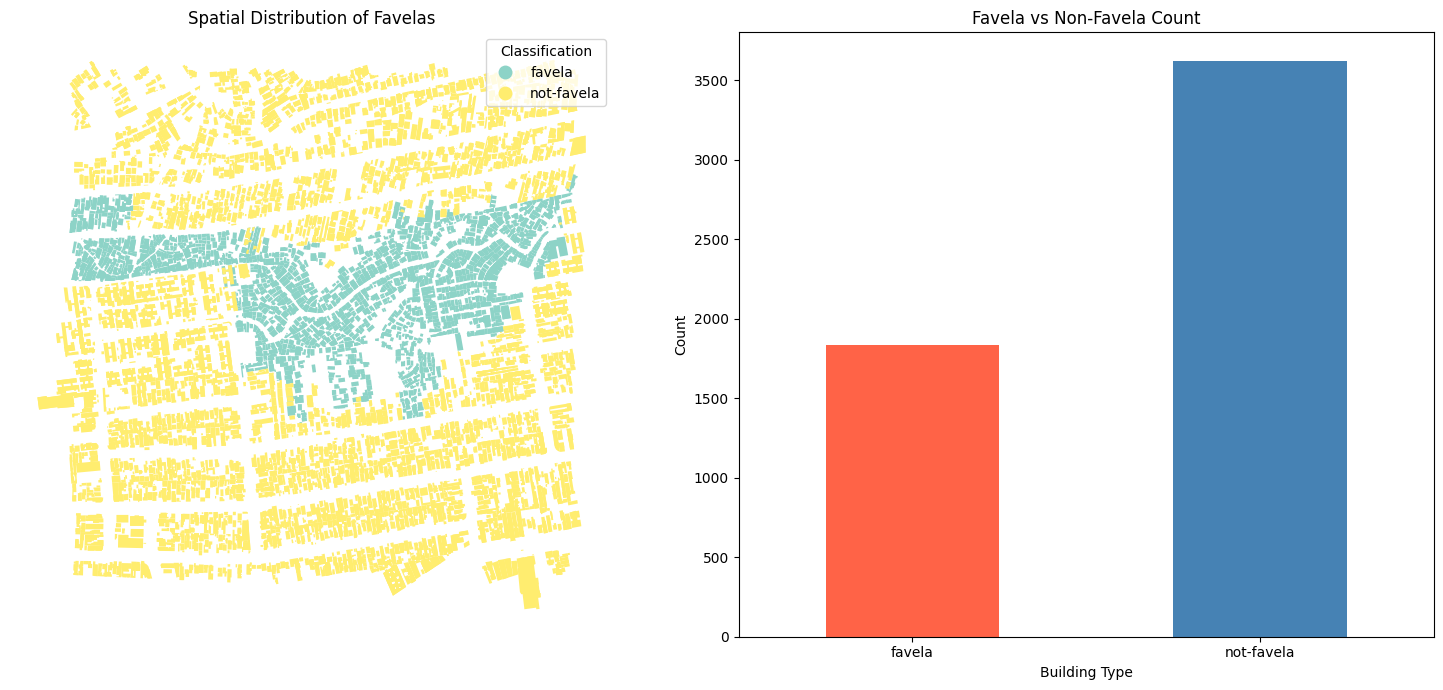

In [9]:
from ground_truth import classify_and_analyze_favelas

try:
    classified_buildings, analysis = classify_and_analyze_favelas(
        clean_buildings,
        type_column='nome_count'
    )

    ground_truth_gdf = classified_buildings

    # merge buildings
    clean_buildings['label'] = classified_buildings['label']

    plt.show()

except Exception as e:
    print(f"Error during classification analysis: {str(e)}")


# XG Boost Classification

In [10]:
from xg_boost_calculator import run_xgboost, save_xgboost_results

results = run_xgboost(ground_truth_gdf)

# save results
save_xgboost_results(results, save_outputs_to, site_name)

ground_truth_gdf = results['updated_gdf']
metrics = results['metrics']
xgb_model = results['model']
X_imputed = results['X_imputed']
X = results['X']
X_train = results['X_train']

print(results['classification_report'])


Target value counts:
0    3621
1    1833
Name: count, dtype: int64
Accuracy: 95.60036663611365
Classification Report:
{'favela': {'precision': 0.9775596072931276, 'recall': 0.9561042524005487, 'f1-score': 0.9667128987517337, 'support': 729.0}, 'not-favela': {'precision': 0.9153439153439153, 'recall': 0.9558011049723757, 'f1-score': 0.9351351351351351, 'support': 362.0}, 'accuracy': 0.9560036663611365, 'macro avg': {'precision': 0.9464517613185215, 'recall': 0.9559526786864623, 'f1-score': 0.9509240169434344, 'support': 1091.0}, 'weighted avg': {'precision': 0.9569160871413268, 'recall': 0.9560036663611365, 'f1-score': 0.9562352173317442, 'support': 1091.0}}
Feature Importances:
                        Feature  Importance
4   mean_interbuilding_distance    0.460992
11                   squareness    0.089941
5                     adjacency    0.056794
16                num_neighbors    0.034619
3                neighbour_dist    0.030920
15               perimeter_wall    0.028405
19   

## SHAP Calculations


In [11]:
from shap_calculator import calculate_shap_results, save_shap_results

shap_results_dict = calculate_shap_results(xgb_model, X_imputed, metrics, ground_truth_gdf)

save_shap_results(shap_results_dict, save_outputs_to, site_name)


 99%|===================| 5388/5454 [00:36<00:00]        C:\Users\miles\favela_analysis\src\shap_calculator.py:78: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  updated_gdf.to_file(shapefile_path)


SHAP results successfully saved to: C:\Users\miles\favela_analysis\output\morro_da_guaiba


In [ ]:
shap_values = shap_results_dict['shap_values']


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as pl

xgb.plot_importance(xgb_model)
pl.title("Feature Importance (Default: Weight)")
pl.show()


In [ ]:
xgb.plot_importance(xgb_model, importance_type="cover")
pl.title('Feature Importance by Cover')
pl.show()


In [ ]:
xgb.plot_importance(xgb_model, importance_type="gain")
pl.title('Feature Importance by Gain')
pl.show()


In [ ]:
import shap

shap.initjs()
# 1. SHAP Force Plot for Many Predictions
# Visualize predictions for the first 1000 buildings
X_display = pd.DataFrame(X_imputed, columns=X.columns)  # Ensure proper column names for SHAP

shap.force_plot(
    explainer.expected_value,  # Use scalar directly
    shap_values.values[:1000, :],
    X_display.iloc[:1000, :]
)


In [ ]:
import shap
# 2. SHAP Bar Chart of Mean Importance
# Plot the mean SHAP values as a bar chart
shap.summary_plot(shap_values.values, X_display, plot_type="bar")
plt.show()



In [ ]:
# 3. SHAP Summary Plot (Density Scatter Plot)
# Plot the density scatter plot for SHAP values
shap.summary_plot(shap_values.values, X_display)
plt.show()



In [ ]:
# Create SHAP dependence plots for each feature in X_train
# for name in X_train.columns:
#     shap.dependence_plot(name, shap_values.values, X_imputed, display_features=X_display)

for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_imputed, display_features=X_display)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values.values[:1000, :])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values.values[:1000, :])


In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cdict1 = {
    "red": (
        (0.0, 0.11764705882352941, 0.11764705882352941),
        (1.0, 0.9607843137254902, 0.9607843137254902),
    ),
    "green": (
        (0.0, 0.5333333333333333, 0.5333333333333333),
        (1.0, 0.15294117647058825, 0.15294117647058825),
    ),
    "blue": (
        (0.0, 0.8980392156862745, 0.8980392156862745),
        (1.0, 0.3411764705882353, 0.3411764705882353),
    ),
    "alpha": ((0.0, 1, 1), (0.5, 1, 1), (1.0, 1, 1)),
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap("RedBlue", cdict1)


In [ ]:
import numpy as np

f = pl.figure(figsize=(5, 5))
pl.scatter(
    shap_embedded[:, 0],
    shap_embedded[:, 1],
    c=shap_values.values[:1000, :].sum(1).astype(np.float64),  # Use .values here
    linewidth=0,
    alpha=1.0,
    cmap=red_blue_solid,
)
cb = pl.colorbar(label="Favela vs Not Favela", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.outline.set_linewidth(0)
cb.ax.tick_params("x", length=0)
cb.ax.xaxis.set_label_position("top")
pl.gca().axis("off")
pl.show()


In [ ]:
for feature in ['area', 'perimeter', 'lal', 'neighbour_dist',
           'mean_interbuilding_distance', 'adjacency', 'corners', 'shape_idx',
           'facade_ratio', 'compact_weighted_axis', 'circular_com',
           'squareness', 'square_compact', 'rectangularity', 'rect_idx',
           'perimeter_wall', 'num_neighbors',
           'elongation', 'fractal', 'cwa', 'CAR', 'tes_area', 'shared_walls']:
    f = pl.figure(figsize=(5, 5))
    pl.scatter(
        shap_embedded[:, 0],
        shap_embedded[:, 1],
        c=X[feature].values[:1000].astype(np.float64),
        linewidth=0,
        alpha=1.0,
        cmap=red_blue_solid,
    )
    cb = pl.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.outline.set_linewidth(0)
    cb.ax.tick_params("x", length=0)
    cb.ax.xaxis.set_label_position("top")
    pl.gca().axis("off")
    pl.show()


In [ ]:
# Plot the classified buildings
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf.plot(column='label', cmap='coolwarm', alpha=0.7, legend=True, ax=ax,
         legend_kwds={'loc': 'lower right', 'title': "Predicted Labels"})

scalebar = ScaleBar(1, location='lower left', pad=1, box_alpha=0.5)
ax.add_artist(scalebar)

# Add north arrow
x, y, arrow_length = 0.04, 1, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', headwidth=15, headlength=20, width=5),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# Add resource text
plt.text(0.5, 0.02, 'Data source: OpenStreetMap', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, fontsize=7)

plt.title('Buildings TS Classification using UMMs - Nova Cidade')
ax.set_axis_off()
plt.show()
